### The Reuters corpus

Revisit the Reuters C50 text corpus that we briefly explored in class. Your task is simple: tell an interesting story, anchored in some analytical tools we have learned in this class, using this data. For example:
- you could cluster authors or documents and tell a story about what you find.
- you could look for common factors using PCA.
- you could train a predictive model and assess its accuracy, constructing features for each document that maximize performance.
- you could do anything else that strikes you as interesting with this data.

Describe clearly what question you are trying to answer, what models you are using, how you pre-processed the data, and so forth. Make sure you include at least one really interesting plot (although more than one might be necessary, depending on your question and approach.)

Format your write-up in the following sections, some of which might be quite short:
- Question: What question(s) are you trying to answer? - Approach: What approach/statistical tool did you use to answer the questions? - Results: What evidence/results did your approach provide to answer the questions? (E.g. any numbers, tables, figures as appropriate.) - Conclusion: What are your conclusions about your questions? Provide a written interpretation of your results, understandable to stakeholders who might plausibly take an interest in this data set.

Regarding the data itself: In the C50train directory, you have 50 articles from each of 50 different authors (one author per directory). Then in the C50test directory, you have another 50 articles from each of those same 50 authors (again, one author per directory). This train/test split is obviously intended for building predictive models, but to repeat, you need not do that on this problem. You can tell any story you want using any methods you want. Just make it compelling!

Note: if you try to build a predictive model, you will need to figure out a way to deal with words in the test set that you never saw in the training set. This is a nontrivial aspect of the modeling exercise. (E.g. you might simply ignore those new words.)

This question will be graded according to three criteria:
1. the overall “interesting-ness” of your question and analysis.
2. the clarity of your description. We will be asking ourselves: could your analysis be reproduced by a competent data scientist based on what you’ve said? (That’s good.) Or would that person have to wade into the code in order to understand what, precisely, you’ve done? (That’s bad.)
3. technical correctness (i.e. did you make any mistakes in execution or interpretation?)

In [1]:
# Import packages
import os
import sys
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/twinklepanda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/twinklepanda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/twinklepanda/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Data fetch from GIT Repo
'''Used 'git clone https://github.com/jgscott/STA380.git' on terminal to fetch the files and stored inside P2CourseGitRepo'''

"Used 'git clone https://github.com/jgscott/STA380.git' on terminal to fetch the files and stored inside P2CourseGitRepo"

In [3]:
# Change the directory address for your machine
directory = "/Users/twinklepanda//Desktop/Me/MSBA/Summer/IntroToML/P2CourseGitRepo/data/ReutersC50"

data = []
# Iterate over directories > subdirectories > find the text files > append to form master dataframe
for rep in os.listdir(directory):
    for sub_rep in os.listdir(os.path.join(directory,rep)):
        for txt_file in os.listdir(os.path.join(directory,rep,sub_rep)):
            try:
                with open(os.path.join(directory,rep,sub_rep,txt_file), 'r') as file:
                    content = file.read()
                    content = content.replace('\n', ' ')
                    content = ' '.join(content.split())
                
                data.append({
                    'Repository': rep,
                    'Journalist': sub_rep,
                    'TextFile': txt_file,
                    'Article': content})
            except :
                pass

df = pd.DataFrame(data)

df.head()

,Repository,Journalist,TextFile,Article
0,C50test,RobinSidel,347781newsML.txt,ITT Corp. met with financial advisers on Thurs...
1,C50test,RobinSidel,306379newsML.txt,Norfolk Southern Corp. on Monday launched a ne...
2,C50test,RobinSidel,324849newsML.txt,Long-troubled solid waste firm Mid-American Wa...
3,C50test,RobinSidel,284041newsML.txt,Healthcare and oil companies are expected to b...
4,C50test,RobinSidel,363477newsML.txt,The union of CVS Corp and Revco D.S. Inc creat...


## Question: How do journalists cluster based on their topic preferences?

In [15]:
# Create 1 document per Journalist with all their articles concatenated
journals = df[['Journalist', 'Article']].drop_duplicates()\
                                        .groupby('Journalist')\
                                        .agg(Document = ('Article', ' '.join))\
                                        .reset_index()
journals.iloc[:3]

,Journalist,Document
0,AaronPressman,The U.S. government is scrambling to update th...
1,AlanCrosby,East European markets moved higher across the ...
2,AlexanderSmith,British estate agency and financial products g...


#### Difference between Stemming and Lemmatization
- Stemming: Removes prefixes and suffixes to get the root form of a word
     - "Caring" → "Car" (incorrect root) and "Better" → "Better" (or possibly "Bet")
- Lemmatization: Uses linguistic rules and a dictionary to transform a word into its base form ensuring it remains a valid word
     - "Caring" → "Care" (correct root) and "Better" → "Good" (correct base form)

In [5]:
# Pre-processing: Tokenize, Stop word removal & Lemmatization
stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum()]
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

journals['processed_doc'] = journals['Document'].apply(preprocess_text)

#### Topic Modelling using LDA

In [6]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(journals['processed_doc'])

lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
lda_output = lda_model.fit_transform(doc_term_matrix)

df_topic_distribution = pd.DataFrame(lda_output, columns=[f'Topic_{i+1}' for i in range(10)])
journals = pd.concat([journals, df_topic_distribution], axis=1)

In [7]:
print(''' 
NOTE: 
Here, we see 10 topics because we chose n_components = 10. 
The values in these topic columns are the probabilities that a given document belongs to each topic. 
These probabilities sum to 1 for each document. 

The first document here we see by Aaron Pressman, most likely belongs to topic 1 since the topic distribution probability is 81%.
He has predominantly focused on Topic 1 in his past work, which suggests a strong interest or expertise in that area. 
It doesn't account for any trends, changes in interests, or external factors that might influence his future work. 
Hence, we cannot conclude that there's a 81% chance of his next article to be about topic 1.

''')

journals.head(2)

 
NOTE: 
Here, we see 10 topics because we chose n_components = 10. 
The values in these topic columns are the probabilities that a given document belongs to each topic. 
These probabilities sum to 1 for each document. 

The first document here we see by Aaron Pressman, most likely belongs to topic 1 since the topic distribution probability is 81%.
He has predominantly focused on Topic 1 in his past work, which suggests a strong interest or expertise in that area. 
It doesn't account for any trends, changes in interests, or external factors that might influence his future work. 
Hence, we cannot conclude that there's a 81% chance of his next article to be about topic 1.




,Journalist,Document,processed_doc,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10
0,AaronPressman,The U.S. government is scrambling to update th...,government scrambling update thousand computer...,0.817386,0.000006,0.182563,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006
1,AlanCrosby,East European markets moved higher across the ...,east european market moved higher across board...,0.999930,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008


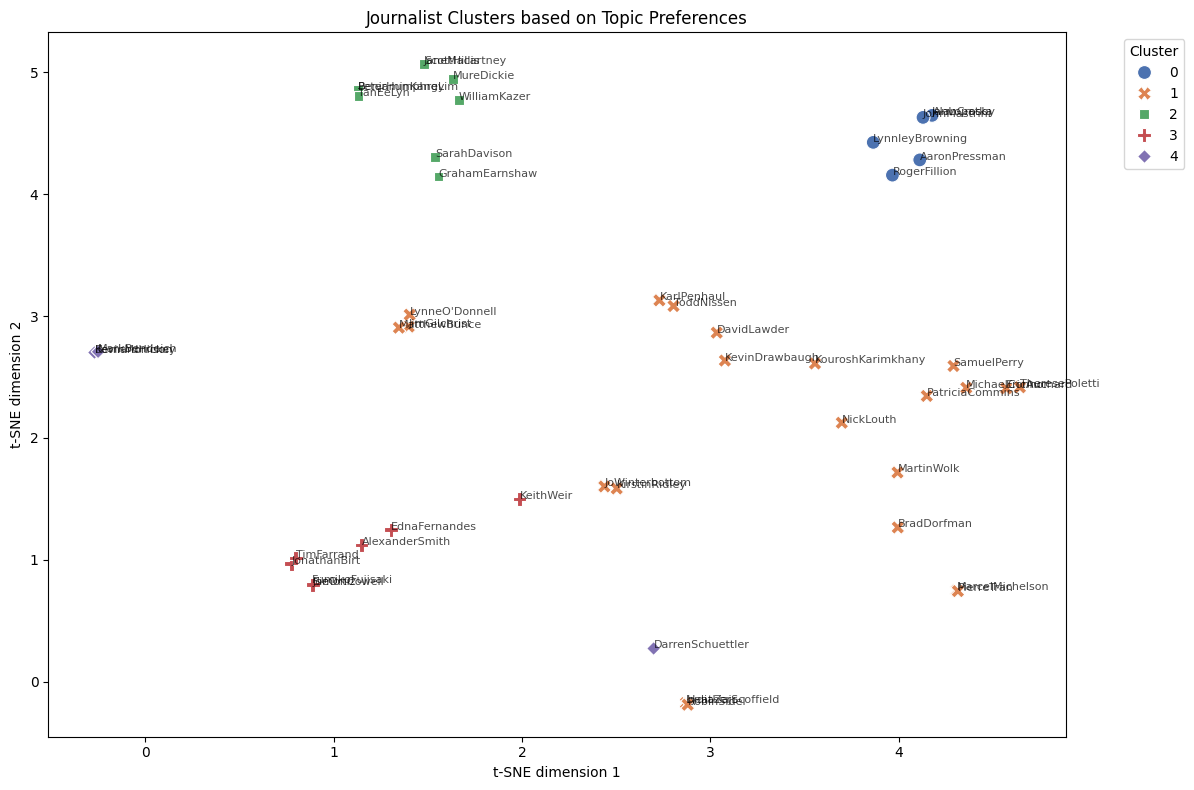

In [8]:
# Cluster the journals based on topic distribution
kmeans = KMeans(n_clusters=5, random_state=42)
journals['Cluster'] = kmeans.fit_predict(df_topic_distribution)

# Perform t-SNE to reduce to 2 dimensions for plotting
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(df_topic_distribution)

df_tsne = pd.DataFrame(data=tsne_results, columns=['tsne1', 'tsne2'])
df_tsne['Cluster'] = journals['Cluster']
df_tsne['Journalist'] = journals['Journalist']

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_tsne, x='tsne1', y='tsne2', hue='Cluster', style='Cluster', s=100, palette='deep')

for i, txt in enumerate(df_tsne['Journalist']):
    plt.annotate(txt, (df_tsne['tsne1'].iloc[i], df_tsne['tsne2'].iloc[i]), fontsize=8, alpha=0.7)

plt.title('Journalist Clusters based on Topic Preferences')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [17]:
# journals[journals['Cluster']==1]
print(
'''
NOTE: 
We are able to successfully cluster the journalists together except for some variability in cluster 1.
Journalists like KirstinRidley, LynneO'Donnell & HeatherScoffield seem to be farther away from the cluster. 
This could be because they focus majorly on one topic among the 10, when most other journalists tend to pick more topics for their articles. 
'''
)


NOTE: 
We are able to successfully cluster the journalists together except for some variability in cluster 1.
Journalists like KirstinRidley, LynneO'Donnell & HeatherScoffield seem to be farther away from the cluster. 
This could be because they focus majorly on one topic among the 10, when most other journalists tend to pick more topics for their articles. 



In [9]:
# Get features corresponding to each topic:
feature_names = vectorizer.get_feature_names_out()

def display_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx + 1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print("\n")

n_top_words = 10  # Number of top words you want to see per topic
display_topics(lda_model, feature_names, n_top_words)

Topic #1:
czech, crown, russia, prague, oil, foreign, export, fcc, russian, klaus


Topic #2:
gm, ford, plant, worker, apple, car, strike, vehicle, chrysler, automaker


Topic #3:
computer, internet, software, network, revenue, earnings, microsoft, amp, ibm, online


Topic #4:
franc, french, boeing, france, airbus, air, thomson, defence, lagardere, electronics


Topic #5:
pound, british, amp, telecom, bt, penny, mci, cable, television, communication


Topic #6:
gold, canada, toronto, canadian, busang, shareholder, barrick, csx, indonesian, southern


Topic #7:
tonne, trader, export, china, cargo, cocoa, kong, hong, chinese, crop


Topic #8:
pound, british, britain, penny, london, insurance, japan, plc, amp, nomura


Topic #9:
australia, australian, net, cent, sydney, earnings, asia, mutual, banking, casino


Topic #10:
china, hong, kong, beijing, chinese, foreign, party, deng, political, taiwan




### Topic Knowledge: 

- Topic 1 : Czech economic and foreign relations, particularly with Russia.
- Topic 2 : Automotive industry news, focusing on major American manufacturers.
- Topic 3 : Technology and software industry developments, including major tech companies.
- Topic 4 : French aerospace and defense industry, with emphasis on Airbus.
- Topic 5 : British telecommunications sector, including BT and cable TV.
- Topic 6 : Canadian mining and resource industry, with focus on gold.
- Topic 7 : International trade and commodities, particularly involving China.
- Topic 8 : British financial sector and international business relations.
- Topic 9 : Australian business and finance, including banking and gambling industries.
- Topic 10 : Chinese politics and international relations, including Hong Kong and Taiwan.

### Significance of this project:

This analysis can help in the following ways:

- Tailored content delivery: Clustering helps news platforms match articles to reader interests, creating a more personalized news experience.
- Expert source identification: This approach highlights journalists with expertise in specific topics, making it easier for readers to find authoritative coverage.
- Strategic content planning: News organizations can use clustering insights to assign stories based on journalists' strengths, aligning content with audience demand.

These applications show how data analysis can enhance both the reader experience and newsroom efficiency.